# Generative Adversarial Network

### By MMA

In [1]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model Inputs

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    return inputs_real, inputs_z

## Generator network


In [5]:
def generator(z, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.dense(z, 1024)
        # ReLU 1
        h1 = tf.maximum(h1, 0)
        
        # Hidden layer 2
        h2 = tf.layers.dense(h1, 1024)
        # ReLU 2
        h2 = tf.maximum(h2, 0)
        # Logits and tanh output
        logits = tf.layers.dense(h2, 784)
        out = tf.nn.tanh(logits)
        
        return out, logits

## Discriminator

In [6]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.dense(x, 256)
        # Leaky ReLU 1
        h1 = tf.maximum(h1, 0.01*h1)
        
        # Hidden Layer 2
        h2 = tf.layers.dense(h1, 256)
        # Leaky ReLU 2
        h2 = tf.maximum(h2, 0.01*h2)
        logits = tf.layers.dense(h2, 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [7]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build network

In [8]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model, g_logits = generator(input_z, reuse=False)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, reuse=False)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

## Discriminator and Generator Losses

In [9]:
# Calculate losses
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake), 
        logits=d_logits_fake))

## Optimizers


In [10]:
# Optimizers
learning_rate = 0.001

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(g_loss, var_list=g_vars)

## Training

In [12]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 1.0619... Generator Loss: 1.2310


Epoch 2/100... Discriminator Loss: 1.3699... Generator Loss: 0.7619


Epoch 3/100... Discriminator Loss: 1.2291... Generator Loss: 0.9742


Epoch 4/100... Discriminator Loss: 1.3385... Generator Loss: 0.8675


Epoch 5/100... Discriminator Loss: 1.3543... Generator Loss: 0.8122


Epoch 6/100... Discriminator Loss: 1.3064... Generator Loss: 0.8903


Epoch 7/100... Discriminator Loss: 1.2973... Generator Loss: 0.8360


Epoch 8/100... Discriminator Loss: 1.3407... Generator Loss: 0.8167


Epoch 9/100... Discriminator Loss: 1.3146... Generator Loss: 0.9057


Epoch 10/100... Discriminator Loss: 1.3175... Generator Loss: 0.8085


Epoch 11/100... Discriminator Loss: 1.2784... Generator Loss: 0.8760


Epoch 12/100... Discriminator Loss: 1.2862... Generator Loss: 0.9416


Epoch 13/100... Discriminator Loss: 1.2683... Generator Loss: 0.8638


Epoch 14/100... Discriminator Loss: 1.2878... Generator Loss: 0.8375


Epoch 15/100... Discriminator Loss: 1.2330... Generator Loss: 0.8216


Epoch 16/100... Discriminator Loss: 1.2342... Generator Loss: 1.0201


Epoch 17/100... Discriminator Loss: 1.1627... Generator Loss: 0.9538


Epoch 18/100... Discriminator Loss: 1.1765... Generator Loss: 1.0313


Epoch 19/100... Discriminator Loss: 1.1605... Generator Loss: 1.0223


Epoch 20/100... Discriminator Loss: 1.1877... Generator Loss: 1.0092


Epoch 21/100... Discriminator Loss: 1.1274... Generator Loss: 0.9789


Epoch 22/100... Discriminator Loss: 1.1234... Generator Loss: 1.0539


Epoch 23/100... Discriminator Loss: 1.1181... Generator Loss: 1.1220


Epoch 24/100... Discriminator Loss: 1.1946... Generator Loss: 0.9551


Epoch 25/100... Discriminator Loss: 1.1727... Generator Loss: 1.1487


Epoch 26/100... Discriminator Loss: 1.1557... Generator Loss: 1.0557


Epoch 27/100... Discriminator Loss: 1.1549... Generator Loss: 1.0029


Epoch 28/100... Discriminator Loss: 1.1754... Generator Loss: 1.0606


Epoch 29/100... Discriminator Loss: 1.2294... Generator Loss: 0.8292


Epoch 30/100... Discriminator Loss: 1.1554... Generator Loss: 1.0006


Epoch 31/100... Discriminator Loss: 1.1290... Generator Loss: 0.9796


Epoch 32/100... Discriminator Loss: 1.1686... Generator Loss: 1.0243


Epoch 33/100... Discriminator Loss: 1.1837... Generator Loss: 1.1754


Epoch 34/100... Discriminator Loss: 1.2102... Generator Loss: 0.9953


Epoch 35/100... Discriminator Loss: 1.1910... Generator Loss: 1.0311


Epoch 36/100... Discriminator Loss: 1.1383... Generator Loss: 1.0895


Epoch 37/100... Discriminator Loss: 1.0892... Generator Loss: 0.8914


Epoch 38/100... Discriminator Loss: 1.1820... Generator Loss: 0.8798


Epoch 39/100... Discriminator Loss: 1.1809... Generator Loss: 0.9199


Epoch 40/100... Discriminator Loss: 1.1021... Generator Loss: 0.9664


Epoch 41/100... Discriminator Loss: 1.2114... Generator Loss: 1.0701


Epoch 42/100... Discriminator Loss: 1.2064... Generator Loss: 0.9175


Epoch 43/100... Discriminator Loss: 1.2497... Generator Loss: 0.9889


Epoch 44/100... Discriminator Loss: 1.1743... Generator Loss: 0.9082


Epoch 45/100... Discriminator Loss: 1.1018... Generator Loss: 1.0565


Epoch 46/100... Discriminator Loss: 1.1803... Generator Loss: 0.9082


Epoch 47/100... Discriminator Loss: 1.1733... Generator Loss: 1.0196


Epoch 48/100... Discriminator Loss: 1.2633... Generator Loss: 0.9521


Epoch 49/100... Discriminator Loss: 1.1419... Generator Loss: 1.1179


Epoch 50/100... Discriminator Loss: 1.1832... Generator Loss: 1.0090


Epoch 51/100... Discriminator Loss: 1.0990... Generator Loss: 1.1185


Epoch 52/100... Discriminator Loss: 1.1882... Generator Loss: 1.1158


Epoch 53/100... Discriminator Loss: 1.1261... Generator Loss: 1.1068


Epoch 54/100... Discriminator Loss: 1.1912... Generator Loss: 0.9622


Epoch 55/100... Discriminator Loss: 1.1587... Generator Loss: 1.1027


Epoch 56/100... Discriminator Loss: 1.1319... Generator Loss: 1.0244


Epoch 57/100... Discriminator Loss: 1.1101... Generator Loss: 1.0316


Epoch 58/100... Discriminator Loss: 1.1738... Generator Loss: 0.9037


Epoch 59/100... Discriminator Loss: 1.1907... Generator Loss: 0.8577


Epoch 60/100... Discriminator Loss: 1.1550... Generator Loss: 1.0068


Epoch 61/100... Discriminator Loss: 1.1599... Generator Loss: 0.9078


Epoch 62/100... Discriminator Loss: 1.1478... Generator Loss: 0.9303


Epoch 63/100... Discriminator Loss: 1.1267... Generator Loss: 0.9393


Epoch 64/100... Discriminator Loss: 1.1591... Generator Loss: 0.9943


Epoch 65/100... Discriminator Loss: 1.1098... Generator Loss: 1.0677


Epoch 66/100... Discriminator Loss: 1.1125... Generator Loss: 1.0741


Epoch 67/100... Discriminator Loss: 1.1644... Generator Loss: 0.9771


Epoch 68/100... Discriminator Loss: 1.1421... Generator Loss: 0.9770


Epoch 69/100... Discriminator Loss: 1.1937... Generator Loss: 1.0423


Epoch 70/100... Discriminator Loss: 1.0883... Generator Loss: 1.1088


Epoch 71/100... Discriminator Loss: 1.1097... Generator Loss: 1.0590


Epoch 72/100... Discriminator Loss: 1.0861... Generator Loss: 1.1391


Epoch 73/100... Discriminator Loss: 1.1341... Generator Loss: 1.0115


Epoch 74/100... Discriminator Loss: 1.1922... Generator Loss: 1.0761


Epoch 75/100... Discriminator Loss: 1.0900... Generator Loss: 1.2093


Epoch 76/100... Discriminator Loss: 1.0371... Generator Loss: 1.2079


Epoch 77/100... Discriminator Loss: 1.1627... Generator Loss: 1.0371


Epoch 78/100... Discriminator Loss: 1.0525... Generator Loss: 1.1205


Epoch 79/100... Discriminator Loss: 1.0564... Generator Loss: 1.1699


Epoch 80/100... Discriminator Loss: 1.1571... Generator Loss: 1.0589


Epoch 81/100... Discriminator Loss: 1.1321... Generator Loss: 1.1733


Epoch 82/100... Discriminator Loss: 1.1421... Generator Loss: 1.1589


Epoch 83/100... Discriminator Loss: 1.1478... Generator Loss: 1.1895


Epoch 84/100... Discriminator Loss: 1.1318... Generator Loss: 1.0129


Epoch 85/100... Discriminator Loss: 1.1495... Generator Loss: 1.0189


Epoch 86/100... Discriminator Loss: 1.0545... Generator Loss: 1.1065


Epoch 87/100... Discriminator Loss: 1.1059... Generator Loss: 1.0714


Epoch 88/100... Discriminator Loss: 1.0863... Generator Loss: 1.1682


Epoch 89/100... Discriminator Loss: 1.1309... Generator Loss: 1.1577


Epoch 90/100... Discriminator Loss: 1.1041... Generator Loss: 1.0619


Epoch 91/100... Discriminator Loss: 1.0984... Generator Loss: 1.1063


Epoch 92/100... Discriminator Loss: 1.1718... Generator Loss: 1.0280


Epoch 93/100... Discriminator Loss: 1.0856... Generator Loss: 1.1777


Epoch 94/100... Discriminator Loss: 1.0931... Generator Loss: 1.0625


Epoch 95/100... Discriminator Loss: 1.0310... Generator Loss: 1.2195


Epoch 96/100... Discriminator Loss: 1.1221... Generator Loss: 1.0934


Epoch 97/100... Discriminator Loss: 1.0615... Generator Loss: 1.1226


Epoch 98/100... Discriminator Loss: 1.1016... Generator Loss: 1.2501


Epoch 99/100... Discriminator Loss: 1.1207... Generator Loss: 1.1782


Epoch 100/100... Discriminator Loss: 1.0735... Generator Loss: 1.0248


## Training loss


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

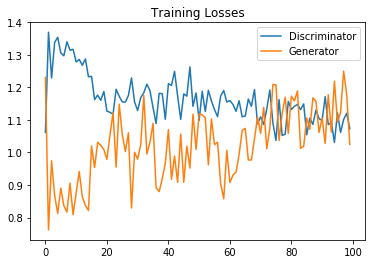

In [14]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [15]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [16]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

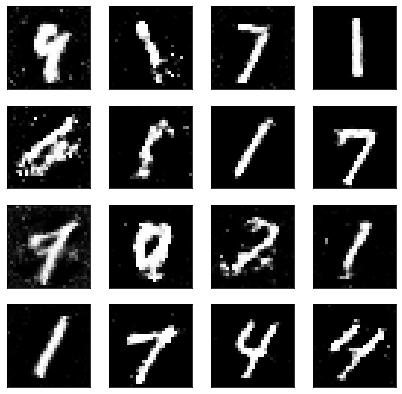

In [17]:
_ = view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

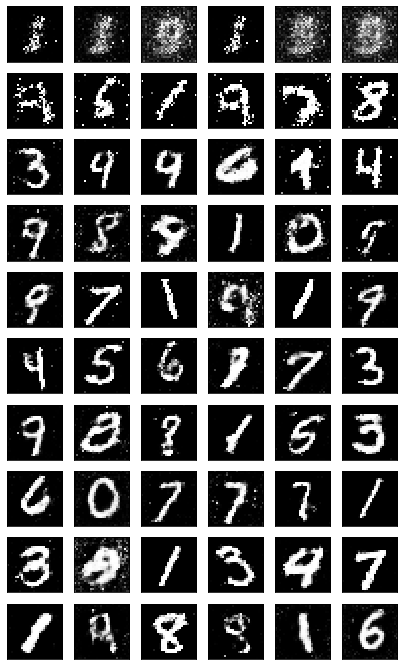

In [21]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample[0])/cols)][0], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator


INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<Figure size 504x504 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafb7e07438>,
       dtype=object))

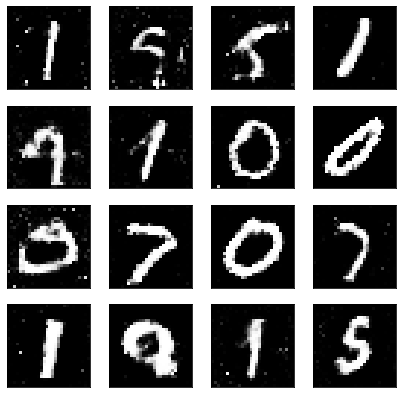

In [20]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, reuse=True),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])